In [ ]:
!pip install --quiet --upgrade langgraph langchain-neo4j langchain-openai langchain-mcp-adapters

**LangGraph** is a framework for building stateful, multi-actor applications with LLMs. It provides cyclical graph structures for agent workflows, built-in persistence and human-in-the-loop patterns, streaming support, and first-class support for tool calling and agentic patterns. While it seamlessly integrates with the LangChain ecosystem, it can be used entirely standalone without LangChain as a dependency.

In this notebook, you'll build a company research agent that queries a Neo4j graph database. You'll use **LangChain** for Neo4j, MCP, and LLM integrations.

In [2]:
import base64
import json
import operator
from typing import Literal
from pydantic import BaseModel

from langchain_core.tools import StructuredTool

from typing_extensions import Annotated, TypedDict
from IPython.display import Image, display

from langchain.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_neo4j import Neo4jGraph, Neo4jVector, AsyncNeo4jSaver
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import END, START, StateGraph

LangChain integrates with virtually every major LLM provider like OpenAI, Anthropic, Google, Cohere, Mistral, AWS Bedrock, Azure, and many more. This makes it easy to swap models or run comparisons without rewriting your application logic.

In this example, we'll use OpenAI as our LLM provider, specifically GPT-5.1

In [3]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("OpenAI API key")

OpenAI API key··········


In [4]:
model =  ChatOpenAI(model="gpt-5.1")

## Neo4j MCP Server

We'll start by using the official [Neo4j MCP Server](https://github.com/neo4j/mcp) to extend the agent with Neo4j tools. This MCP server provides the agent with capabilities to read the graph schema and execute Cypher queries, enabling it to fetch and analyze data directly from the database.

The following code installs the latest version on Google Colab and similar Linux-based systems. For other operating systems, please consult the [official installation documentation](https://neo4j.com/docs/mcp/current/installation/).

In [5]:
import requests

# Get latest release info from GitHub API
release = requests.get("https://api.github.com/repos/neo4j/mcp/releases/latest").json()
version = release["tag_name"]
print(f"Latest version: {version}")

# Download the latest Linux binary
!wget -q https://github.com/neo4j/mcp/releases/download/{version}/neo4j-mcp_Linux_x86_64.tar.gz

# Extract
!tar -xzf neo4j-mcp_Linux_x86_64.tar.gz

# Make executable
!chmod +x neo4j-mcp

# Cleanup
!rm neo4j-mcp_Linux_x86_64.tar.gz

# Move
!mv neo4j-mcp /usr/local/bin/

# Verify installation
!neo4j-mcp -v

Latest version: v1.2.0
neo4j-mcp version: v1.2.0


For this example, we'll use the companies database from the Neo4j demo server, which contains organizations, people, investors, and news articles.

For HTTP transport, you only need to set the `NEO4J_URI` and optionally `NEO4J_DATABASE` (if connecting to a specific database).

In [6]:
os.environ["NEO4J_URI"] = "neo4j+s://demo.neo4jlabs.com"
os.environ["NEO4J_DATABASE"] = "companies"
os.environ["NEO4J_MCP_TRANSPORT"] = "http"

# Run the server in the background
import subprocess
subprocess.Popen(["neo4j-mcp"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

<Popen: returncode: None args: ['neo4j-mcp']>

Credentials are passed via the `Authorization` header using Basic authentication. The HTTP transport listens on port 80 by default, so the MCP endpoint is available at `http://localhost:80/mcp`.

In [7]:
# Credentials are passed via bearer auth
os.environ["NEO4J_USERNAME"] = "companies"
os.environ["NEO4J_PASSWORD"] = "companies"

credentials = base64.b64encode(f"{os.environ["NEO4J_USERNAME"]}:{os.environ["NEO4J_PASSWORD"]}".encode()).decode()

cypher_mcp_config = {
    "neo4j-database": {
        "transport": "http",
        "url": "http://localhost:80/mcp",
        "headers": {
            "Authorization": f"Basic {credentials}"
        },
    }
}

With the MCP server running, we initialize a client to connect to it and retrieve the available tools. These tools will allow our agent to query the Neo4j database.

In [8]:
# If there is an error, just rerun as the MCP server might not be running yet

client = MultiServerMCPClient(cypher_mcp_config)
mcp_tools = await client.get_tools()

## Temporary Workaround

The `get-schema` and `list-gds-procedures` tools return an invalid `args_schema` format (`{'type': 'object'}` dict instead of a Pydantic `BaseModel` class). This causes validation errors when the tools are invoked.

The following workaround replaces the malformed schema in `langchain` with a proper empty Pydantic model until the upstream MCP adapter is fixed.

In [9]:
# Create an empty schema for tools with no arguments
class EmptySchema(BaseModel):
    """Schema for tools that take no arguments."""
    pass

def fix_empty_args_schema(tools: list[StructuredTool]) -> list[StructuredTool]:
    """Fix tools that have dict-based empty schemas instead of proper Pydantic models."""
    fixed_tools = []
    for tool in tools:
        # Check if args_schema is a dict (incorrect) instead of a BaseModel class
        if isinstance(tool.args_schema, dict) and tool.args_schema == {'type': 'object'}:
            # Create a new tool with the proper empty schema
            fixed_tool = StructuredTool(
                name=tool.name,
                description=tool.description,
                args_schema=EmptySchema,
                metadata=tool.metadata,
                response_format=tool.response_format,
                coroutine=tool.coroutine,
                func=tool.func,
            )
            fixed_tools.append(fixed_tool)
        else:
            fixed_tools.append(tool)
    return fixed_tools

# Usage:
mcp_tools = fix_empty_args_schema(mcp_tools)

# Custom tools

Beyond using existing MCP servers, you can also implement your own custom tools and add them directly to the agent. This allows you to create specialized functionality tailored to your specific use case. Custom tools can be implemented using the `@tool` decorator, which turns any function into a tool the agent can invoke.

Here, we use `Neo4jGraph` from the `langchain-neo4j` package, a direct integration in the LangChain ecosystem, to establish a connection to our database and build a tool that queries investment relationships, giving you more control over the query logic.


In [10]:
neo4j_graph = Neo4jGraph(refresh_schema=False)

@tool
async def get_investments(company: str) -> str:
    """Returns the investments by a company by name. Returns list of investment ids, names and types."""
    try:
        results = neo4j_graph.query("""
            MATCH (o:Organization)-[:HAS_INVESTOR]->(i)
            WHERE o.name = $company
            RETURN i.id as id, i.name as name, head(labels(i)) as type
        """, {"company": company})
        return json.dumps(results, indent=2)
    except Exception as e:
        raise Exception(f"Error fetching investments: {str(e)}")

The `langchain-neo4j` package also provides `Neo4jVector`, a vector store integration that enables semantic search over your graph data. Here, we connect to an existing vector index and create a tool that uses OpenAI embeddings to search for relevant news chunks.

In [11]:
vector_store = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(),
    index_name="news",
    node_label="Chunk",
    retrieval_query="""
    MATCH (node)<-[:HAS_CHUNK]-(a:Article)
    RETURN node.text AS text, score, {date: a.date} AS metadata
    """
)

@tool
def retrieve_news(query: str) -> str:
    """Search for relevant news articles. Returns up to 5 articles with their source metadata and content."""
    retrieved_docs = vector_store.similarity_search(query, k=5)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized

We combine the MCP tools with our custom tools into a single list and implement a simple agent using LangGraph.

In [12]:
custom_tools = mcp_tools + [get_investments, retrieve_news]

tools_by_name = {tool.name: tool for tool in custom_tools}
model_with_tools = model.bind_tools(custom_tools)

## Building the Agent with LangGraph
LangGraph uses a graph-based approach to define agent workflows. We create a simple ReAct-style agent with two nodes: `llm_call` for generating responses and tool calls, and `tool_node` for executing those tools. The conditional edge determines whether to continue the tool loop or return the final response.

In [13]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

system_prompt = """You are a company research assistant with access to a Neo4j graph database and news data.

Available tools:
- get_schema: Retrieve the database schema. Always call this first before writing Cypher queries. Contains information about companies, people, and similar.
- read_query: Execute Cypher queries against the database. Use the schema to construct valid queries. Contains information about companies, people, and similar.
- retrieve_news: Fetch recent news articles about companies. Only use this when explicitly asked about news.
- get_investments: Retrieve investment and funding data.

When answering questions:
1. Always use the available tools to gather information—do not rely on prior knowledge.
2. If the question involves database queries, first call get_schema to understand the data model.
3. Write precise Cypher queries based on the actual schema—don't assume node labels or relationship types.
4. Combine multiple tools when needed for comprehensive answers."""

def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content=system_prompt
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }



async def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = await tool.ainvoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}




def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

## Agent State and Logic

We define the agent's state to track messages and LLM calls, then implement the core ReAct loop: the LLM reasons about what tools to call, executes them, observes results, and repeats until it can provide a final answer.

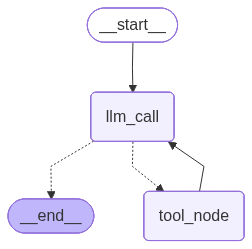

In [14]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Let's test it!

In [15]:
prompt = "Who is the CEO of Neo4j"

messages = [HumanMessage(content=prompt)]
messages = await agent.ainvoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Who is the CEO of Neo4j
================================== Ai Message ==================================
Tool Calls:
  get-schema (call_SHXJEROveGz8z1cBHJT6AjdW)
 Call ID: call_SHXJEROveGz8z1cBHJT6AjdW
  Args:
================================= Tool Message =================================

[{'type': 'text', 'text': '[{"key":"_Bloom_Perspective_","value":{"type":"node","properties":{"data":"STRING","id":"STRING","name":"STRING","roles":"LIST","version":"STRING"},"relationships":{"_Bloom_HAS_SCENE_":{"direction":"out","labels":["_Bloom_Scene_"]}}}},{"key":"HAS_CEO","value":{"type":"relationship"}},{"key":"Organization","value":{"type":"node","properties":{"diffbotId":"STRING","id":"STRING","isDissolved":"BOOLEAN","isPublic":"BOOLEAN","motto":"STRING","name":"STRING","nbrEmployees":"INTEGER","revenue":"FLOAT","summary":"STRING"},"relationships":{"HAS_BOARD_MEMBER":{"direction":"out","labels":["Person"]},"HA

## Short-term memory - Checkpoint saver

LangGraph agents are stateless by default—each invocation starts fresh with no memory of previous interactions. For multi-turn conversations, you need a **checkpointer** to persist the agent's state between calls.

The `langchain-neo4j` package provides `Neo4jSaver` and `AsyncNeo4jSaver`, which store conversation checkpoints directly in Neo4j. This enables:
- **Conversation continuity** across multiple interactions
- **Session recovery** if the application restarts

In [16]:
CHECKPOINT_NEO4J_URI = "bolt://44.203.8.239:7687"
CHECKPOINT_NEO4J_USERNAME = "neo4j"
CHECKPOINT_NEO4J_PASSWORD = "reenlistment-quarts-battleship"
CHECKPOINT_NEO4J_DATABASE = "neo4j"

async with await AsyncNeo4jSaver.from_conn_string(
    uri=CHECKPOINT_NEO4J_URI,
    user=CHECKPOINT_NEO4J_USERNAME,
    password=CHECKPOINT_NEO4J_PASSWORD,
    database=CHECKPOINT_NEO4J_DATABASE
) as checkpointer:
    await checkpointer.setup()

    # Compile the agent
    agent = agent_builder.compile(checkpointer=checkpointer)

    messages = [HumanMessage(content=prompt)]
    messages = await agent.ainvoke(
        {"messages": messages},
        {"configurable": {"thread_id": "12345"}}
        )
    for m in messages["messages"]:
        m.pretty_print()

================================ Human Message =================================

Who is the CEO of Neo4j
================================== Ai Message ==================================
Tool Calls:
  get-schema (call_MIi0pCfNOaNvIGAUTf69HF2d)
 Call ID: call_MIi0pCfNOaNvIGAUTf69HF2d
  Args:
================================= Tool Message =================================

[{'type': 'text', 'text': '[{"key":"_Bloom_Perspective_","value":{"type":"node","properties":{"data":"STRING","id":"STRING","name":"STRING","roles":"LIST","version":"STRING"},"relationships":{"_Bloom_HAS_SCENE_":{"direction":"out","labels":["_Bloom_Scene_"]}}}},{"key":"HAS_CEO","value":{"type":"relationship"}},{"key":"Organization","value":{"type":"node","properties":{"diffbotId":"STRING","id":"STRING","isDissolved":"BOOLEAN","isPublic":"BOOLEAN","motto":"STRING","name":"STRING","nbrEmployees":"INTEGER","revenue":"FLOAT","summary":"STRING"},"relationships":{"HAS_BOARD_MEMBER":{"direction":"out","labels":["Person"]},"HA

## Summary
In this notebook, we built a company research agent using LangGraph with Neo4j:
1. **MCP Integration** — Connected to Neo4j using the official Neo4j MCP server for schema reading and Cypher queries
2. **Graph-Based Workflow** — Used LangGraph's `StateGraph` to define a ReAct-style agent with explicit nodes (`llm_call`, `tool_node`) and conditional edges
3. **Custom Tools** — Built specialized tools using LangChain's `@tool` decorator (`get_investments`, `retrieve_news`) with `Neo4jGraph` and `Neo4jVector`
4. **Short-term Memory** — Added conversation persistence with `AsyncNeo4jSaver` to enable multi-turn interactions

LangGraph provides stateful, graph-based orchestration for complex agent workflows, while LangChain complements it with tool integrations, MCP adapters, and database connectors—allowing you to use each framework's strengths together.

*Note: LangGraph doesn't depend on LangChain and can be used standalone with other frameworks or direct provider APIs if preferred.*